In [254]:
import sys
from pyspark import SparkContext, SparkConf
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
from scipy import stats, integrate

In [2]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [5]:
# np.set_printoptions(threshold=np.nan)

### Step1: Collect train data a d lable data

In [13]:
# define the function to get the train data using spark.
def getTrainData(path):
    train_file = sc.textFile(path)
    traindata = train_file.map(lambda line: line.split("\t")).collect()
    X_df = pd.DataFrame(traindata)
    return X_df

In [270]:
# define the function to get the lable data using spark.
def getLableData(path):
    lable_file = sc.textFile(path)
    labeldata = lable_file.map(lambda line: line.split(" ")).collect()
    y_df = pd.DataFrame(labeldata)
    return y_df

In [271]:
# # get the small size data and lable
# X_df = getTrainData('/Users/wentingsu/Downloads/orange_small_train.data/orange_small_train.data')
# y_df = getLableData('/Users/wentingsu/Downloads/orange_small_train_churn.labels.txt')

In [ ]:
# get the small size data and lable
X_df = getTrainData('dataset/orange_small_train.data')
y_df = getLableData('dataset/orange_small_train_churn.labels.txt')

In [12]:
X_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,220,221,222,223,224,225,226,227,228,229
0,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
1,,,,,,1526,7,,,,...,oslk,fXVEsaq,jySVZNlOJy,,,xb3V,RAYp,F2FyR07IdsN7I,,
2,,,,,,525,0,,,,...,oslk,2Kb5FSF,LM8l689qOp,,,fKCe,RAYp,F2FyR07IdsN7I,,
3,,,,,,5236,7,,,,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,
4,,,,,,,0,,,,...,oslk,CE7uk3u,LM8l689qOp,,,FSa2,RAYp,F2FyR07IdsN7I,,
5,,,,,,1029,7,,,,...,oslk,1J2cvxe,LM8l689qOp,,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,
6,,,,,,658,7,,,,...,zCkv,QqVuch3,LM8l689qOp,,,Qcbd,02N6s8f,Zy3gnGM,am7c,
7,,,,,,1680,7,,,,...,oslk,XlgxB9z,LM8l689qOp,,kG3k,FSa2,RAYp,55YFVY9,am7c,
8,,,,,,77,0,,,,...,oslk,R2LdzOv,,,,FSa2,RAYp,F2FyR07IdsN7I,,
9,,,,,,1176,7,,,,...,zCkv,K2SqEo9,jySVZNlOJy,,kG3k,PM2D,6fzt,am14IcfM7tWLrUmRT52KtA,am7c,


### Step2: Processing Missing Data

* 2.1 dealing with String Empty Data

In [34]:
# define the function to process the string empty
def processEmpty(X_df):
    # deal with the string empty 
    X_index = X_df[:1].values.tolist()
    X_df2 = X_df.T.set_index(X_index).T.drop(0)
    X_df3 = X_df2.apply(lambda x: x.str.strip()).replace('', np.nan)
    return X_df3

In [35]:
X_df3 = processEmpty(X_df)

In [37]:
X_df3.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
1,NaN,NaN,NaN,NaN,NaN,1526,7,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,525,0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,5236,7,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,1029,7,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


* 2.2 dealing with Numerical Missing Data

In [38]:
# Processing missing data of the numerical columns
def ProcessMissNum(X_df3):
    # extract the numerical colums
    X_num_df = X_df3.ix[:, :190]
    # drop the columns that all nan
    X_num_df2 = X_num_df.dropna(axis=1, how = 'all')
    # Processing missing numerical data
    X_num = np.array(X_num_df2)
    imputer_num = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0)
    imputer_num.fit(X_num)
    X_num = imputer_num.transform(X_num)
    return X_num

In [39]:
X_num = ProcessMissNum(X_df3)

In [253]:
pd.DataFrame(X_num).head()

,0,1,2,3,4,5,6,7,8,9,...,164,165,166,167,168,169,170,171,172,173
0,0.0,0.0,0.0,0.0,0.0,1526.0,7.0,20.0,0.0,8.0,...,2431310.0,0.0,116778.0,0.0,0.0,0.0,4.0,197.64,462.0,12668.94
1,0.0,0.0,0.0,0.0,0.0,525.0,0.0,20.0,0.0,8.0,...,2431310.0,0.0,116778.0,0.0,0.0,0.0,4.0,197.64,270.0,12668.94
2,0.0,0.0,0.0,0.0,0.0,5236.0,7.0,20.0,0.0,8.0,...,2431310.0,0.0,116778.0,0.0,0.0,0.0,4.0,197.64,270.0,12668.94
3,0.0,0.0,0.0,0.0,0.0,861.0,0.0,20.0,0.0,8.0,...,2431310.0,0.0,116778.0,0.0,0.0,0.0,4.0,197.64,270.0,12668.94
4,0.0,0.0,0.0,0.0,0.0,1029.0,7.0,20.0,0.0,8.0,...,2431310.0,0.0,116778.0,0.0,0.0,0.0,4.0,197.64,270.0,12668.94


* 2.3 Encoding categorical data

In [64]:
from ipykernel import kernelapp as app

In [58]:
# Encoding categorical data
def ProcessMissCat(X_df3):
    # extract the categorical colums
    X_cat_df = X_df3.ix[:,190:]
    # drop the columns that all nan
    X_cat_df2 = X_cat_df.dropna(axis=1, how = 'all')
    return X_cat_df2

# call the function
X_cat_df2 = ProcessMissCat(X_df3)

# Encoding categorical data
cols = X_cat_df2.columns
for col in cols:
    X_cat_df2[col] = X_cat_df2[col].astype('category')
X_cat_df2[cols] = X_cat_df2[cols].apply(lambda x: x.cat.codes)

In [256]:
X_cat_df2.head()

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
1,-1,225,25,-1,22,0,177,3302,4015,-1,...,94,4,2964,3,-1,-1,22,2,8,-1
2,-1,91,25,-1,22,0,13,3697,4890,-1,...,10,4,125,0,-1,-1,14,2,8,-1
3,-1,248,5,1,22,0,157,1686,4900,14524,...,1293,0,1610,3,-1,1,10,0,25,0
4,-1,269,25,-1,22,0,202,2575,362,-1,...,1444,4,817,0,-1,-1,7,2,8,-1
5,-1,131,25,1,22,0,208,971,2399,249,...,1731,4,65,0,-1,1,7,2,8,1


* 2.4 Combine the numerical data and categorical data.

In [60]:
# Comnime the numerical columns and categorical columns
X_df_combine = pd.concat([pd.DataFrame(X_num), pd.DataFrame(np.array(X_cat_df2))], axis=1)

In [70]:
X = X_df_combine.iloc[:, :].values

In [61]:
X_df_combine.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.0,0.0,0.0,0.0,0.0,1526.0,7.0,20.0,0.0,8.0,...,94,4,2964,3,-1,-1,22,2,8,-1
1,0.0,0.0,0.0,0.0,0.0,525.0,0.0,20.0,0.0,8.0,...,10,4,125,0,-1,-1,14,2,8,-1
2,0.0,0.0,0.0,0.0,0.0,5236.0,7.0,20.0,0.0,8.0,...,1293,0,1610,3,-1,1,10,0,25,0
3,0.0,0.0,0.0,0.0,0.0,861.0,0.0,20.0,0.0,8.0,...,1444,4,817,0,-1,-1,7,2,8,-1
4,0.0,0.0,0.0,0.0,0.0,1029.0,7.0,20.0,0.0,8.0,...,1731,4,65,0,-1,1,7,2,8,1


* 2.5 Lable Encoding

In [66]:
# deal with the lable y train data 
from sklearn.preprocessing import LabelEncoder

In [67]:
def encodeLable(y_df):
    y = y_df.iloc[:, :].values
    labelencoder_y = LabelEncoder()
    y_train = labelencoder_y.fit_transform(y)
    return y_train

In [258]:
y_train = encodeLable(y_df)

//anaconda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Step3: Feature Scaling

In [74]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

In [86]:
def featureScal(X):
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X)
    return X_train
X_std = featureScal(X)

In [87]:
X_std

array([[-0.03221608, -0.00447218, -0.01561547, ..., -0.11873472,
        -0.34422545, -0.78992218],
       [-0.03221608, -0.00447218, -0.01561547, ..., -0.11873472,
        -0.34422545, -0.78992218],
       [-0.03221608, -0.00447218, -0.01561547, ..., -2.42292097,
         2.27591992,  0.46153881],
       ..., 
       [-0.03221608, -0.00447218, -0.01561547, ..., -0.11873472,
         0.58053174, -0.78992218],
       [-0.03221608, -0.00447218, -0.01561547, ..., -0.11873472,
        -0.34422545, -0.78992218],
       [-0.03221608, -0.00447218, -0.01561547, ..., -0.11873472,
        -0.34422545, -0.78992218]])

In [240]:
pd.DataFrame(X_std).head()

,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,210,211
0,-0.032216,-0.004472,-0.015615,-0.017395,-0.060072,0.098947,0.028396,-0.021218,-0.067359,-0.033587,...,-1.529703,0.014225,0.709993,2.520512,-0.129126,-0.835461,2.049586,-0.118735,-0.344225,-0.789922
1,-0.032216,-0.004472,-0.015615,-0.017395,-0.060072,-0.295609,-1.144997,-0.021218,-0.067359,-0.033587,...,-1.597009,0.014225,-1.688764,-0.282632,-0.129126,-0.835461,0.669891,-0.118735,-0.344225,-0.789922
2,-0.032216,-0.004472,-0.015615,-0.017395,-0.060072,1.561289,0.028396,-0.021218,-0.067359,-0.033587,...,-0.568992,-3.559902,-0.434042,2.520512,-0.129126,1.307021,-0.019957,-2.422921,2.275920,0.461539
3,-0.032216,-0.004472,-0.015615,-0.017395,-0.060072,-0.163171,-1.144997,-0.021218,-0.067359,-0.033587,...,-0.448002,0.014225,-1.104072,-0.282632,-0.129126,-0.835461,-0.537343,-0.118735,-0.344225,-0.789922
4,-0.032216,-0.004472,-0.015615,-0.017395,-0.060072,-0.096952,0.028396,-0.021218,-0.067359,-0.033587,...,-0.218040,0.014225,-1.739460,-0.282632,-0.129126,1.307021,-0.537343,-0.118735,-0.344225,1.713000


In [35]:
# Export to csv
pd.DataFrame(X_std).to_csv('X_train.csv')

In [29]:
# Export to csv
pd.DataFrame(y_train).to_csv('y_train_label.csv')

### Step4: PCA

In [97]:
def pcaPlot(X_std):
    # 1 - Eigendecomposition - Computing Eigenvectors and Eigenvalues
    # Covariance Matrix
    mean_vec = np.mean(X_std, axis=0)
    cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
    # 2.
    cov_mat = np.cov(X_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    #3 sort
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    # plot explained variance ratio
    return var_exp,cum_var_exp

In [101]:
def plotCEV(var_exp,cum_var_exp,n):
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(6, 4))

        plt.bar(range(n), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
        plt.step(range(n), cum_var_exp, where='mid',
             label='cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

In [98]:
var_exp,cum_var_exp = pcaPlot(X_std)

//anaconda/lib/python3.5/site-packages/matplotlib/patches.py:643: ComplexWarning: Casting complex values to real discards the imaginary part
  self._height = float(height)
//anaconda/lib/python3.5/site-packages/matplotlib/patches.py:641: ComplexWarning: Casting complex values to real discards the imaginary part
  self._y = float(xy[1])
//anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


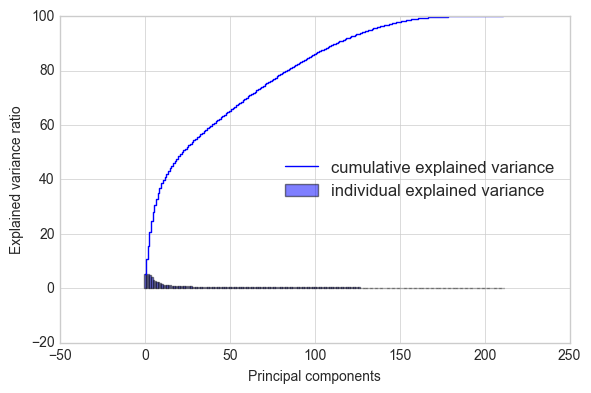

In [100]:
plotCEV(var_exp,cum_var_exp,212)

//anaconda/lib/python3.5/site-packages/matplotlib/patches.py:643: ComplexWarning: Casting complex values to real discards the imaginary part
  self._height = float(height)
//anaconda/lib/python3.5/site-packages/matplotlib/patches.py:641: ComplexWarning: Casting complex values to real discards the imaginary part
  self._y = float(xy[1])


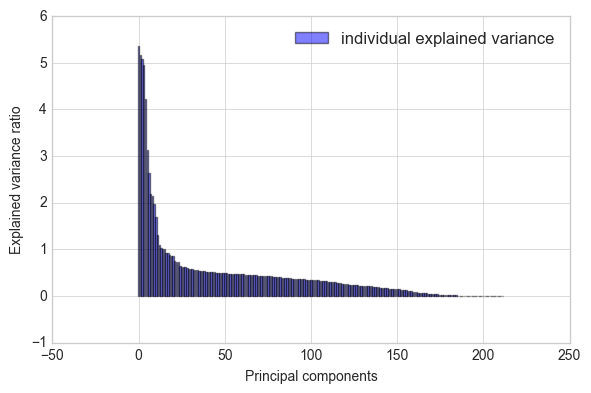

In [95]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(212), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
#     plt.step(range(212), cum_var_exp, where='mid',
#              label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [ ]:
# Correlation Matrix

In [89]:
from sklearn.decomposition import PCA

In [262]:
def DimReduce(X_std, n):
    X = np.array(X_std)
    pca=PCA(n_components=n)
    pca.fit(X)
    X_Train = DataFrame(pca.transform(X))
    return X_Train

In [263]:
X_Train = DimReduce(X_std, 150)

In [ ]:
# print(pca.explained_variance_ratio_) 

### Small dataset export

In [ ]:
# Export to csv
pd.DataFrame(X_std).to_csv('dataset/X_train.csv')

In [ ]:
# Export to csv
pd.DataFrame(y_train).to_csv('dataset/y_train_label.csv')